In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import seaborn as sns

/home/energyls/micromamba/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [3]:
EXPORT = 40
CO2L = 0.00
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.15

RUN = "gadm1_3H_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_Co2L{CO2L}0_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
OUTPUT = PREFIX + "results"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"
OUTPUT_SCENARIO = f"{OUTPUT}/{RUN}/graphics/demand/{SCENARIO}"
OUTPUT_RAW = f"{OUTPUT}/{RUN}/graphics/demand/"

In [4]:
n = pypsa.Network(INPUT)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.00_3H_2030_0.15_DF_40export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Get total demands/loads

Possible demands:
- Should all be in n.loads and n.links

In [5]:
# Get all loads grouped by carrier
loads_raw = n.loads_t.p.groupby(n.loads.carrier, axis=1).sum()
# Get all loads with "emissions" in the name. Note: This does not include emissions from generators as coal etc.
emissions = loads_raw.loc[:, loads_raw.columns.str.contains("emissions")]
# Get all loads without "emissions" in the name
loads = loads_raw.loc[:, ~loads_raw.columns.str.contains("emissions")]

#loads.head()

In [6]:
# Get the annual sum of all loads per carrier in TWh
load_pc = loads.sum(axis=0) * n.snapshot_weightings.generators[0] / 1e6 # TWh

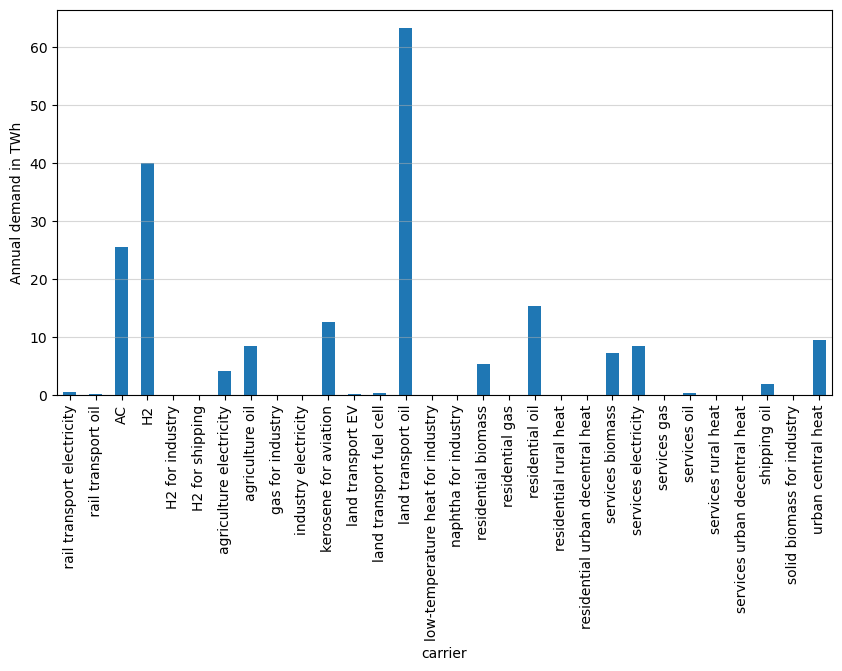

In [7]:
# Stacked barplot of the annual sum of all loads per carrier
fig, ax = plt.subplots(figsize=(10, 5))
load_pc.plot.bar(ax=ax, stacked=True)
ax.set_ylabel("Annual demand in TWh")
ax.grid(axis="y", alpha = 0.5)

### Get hourly demands/loads

In [8]:
# Get total sum of all loads per hour
load_ph = loads.sum(axis=1)

### Hourly demand above threshold

In [9]:
# Get all loads with a total annual sum of above threshold
threshold = 2 * 1e6 # TWh
loads_high = loads.loc[:, loads.sum(axis=0)*n.snapshot_weightings.generators[0] >= threshold]

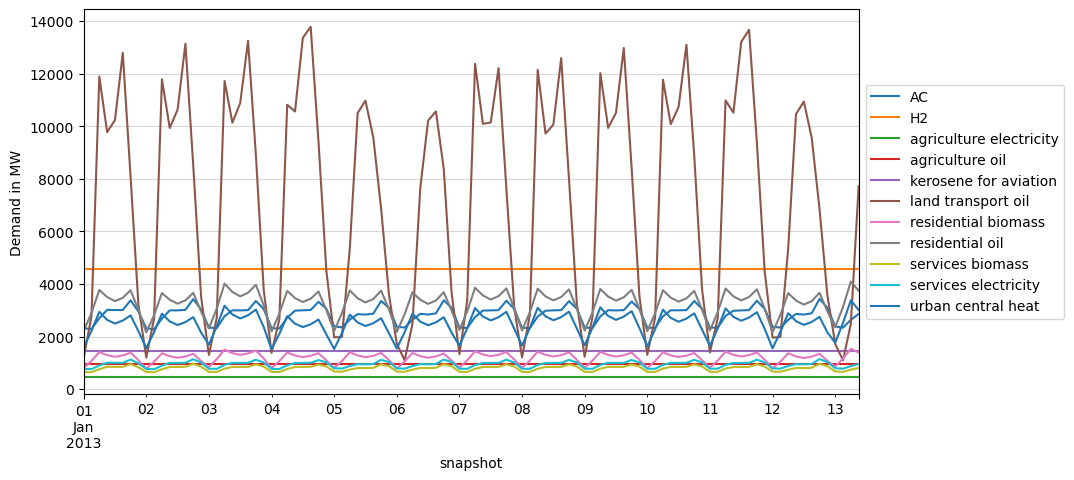

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
loads_high.iloc[:100].plot(ax=ax)
ax.set_ylabel("Demand in MW")
ax.grid(alpha = 0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Loads connected to the electricity bus

In [11]:
# Get all loads which are connected to the bus with carrier "AC"
ac_buses = n.buses[n.buses.carrier == "AC"]
ac_loads = n.loads.loc[n.loads.bus.isin(ac_buses.index)].carrier.unique()
ac_loads

array(['AC', 'industry electricity', ' rail transport electricity',
       'agriculture electricity', 'services electricity'], dtype=object)

In [12]:
# Sum of demand through loads on AC buses
(loads.loc[:, ac_loads].sum() * n.snapshot_weightings.generators[0] / 1e6).round(1) # TWh

carrier
AC                             25.6
industry electricity            0.0
 rail transport electricity     0.6
agriculture electricity         4.1
services electricity            8.5
dtype: float64

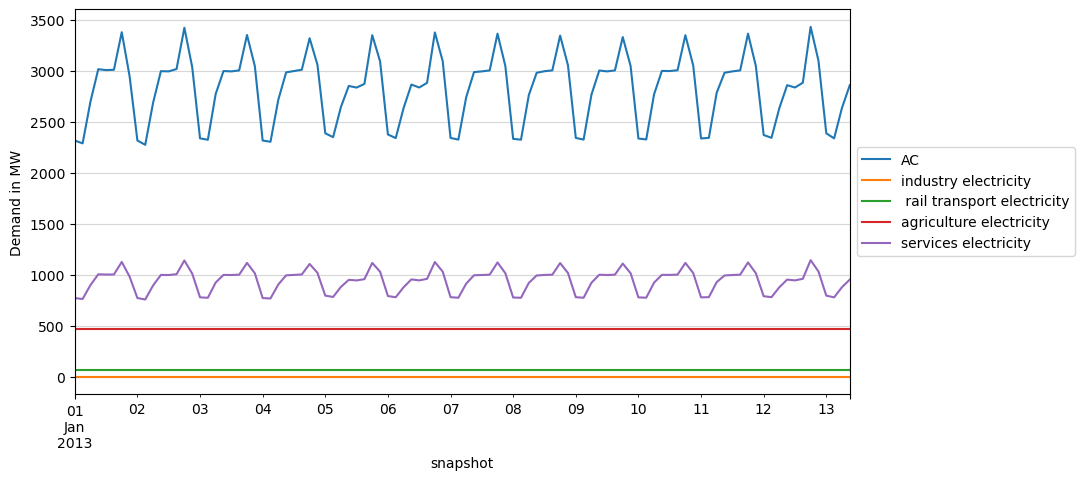

In [13]:
# Select loads with carrier "AC" and plot them
loads_ac = loads.loc[:, ac_loads]
fig, ax = plt.subplots(figsize=(10, 5))
loads_ac.iloc[:100].plot(ax=ax)
ax.set_ylabel("Demand in MW")
ax.grid(alpha = 0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Links connected to arbitrary bus

In [14]:
carrier = "H2" # e.g. "AC", "H2", for "oil" the links need to be changed from bus 0 to bus 1 to see what arrives at the bus
carrier_buses = n.buses[n.buses.carrier == carrier]


n.links.loc[n.links.bus0.isin(carrier_buses.index)].carrier.unique()
carrier_links = n.links.loc[n.links.bus0.isin(carrier_buses.index)].carrier.unique()
carrier_links

array(['H2 Fuel Cell', 'H2 pipeline', 'Fischer-Tropsch', 'Sabatier', 'H2'],
      dtype=object)

In [15]:
# Group all links by carrier and sum them up
links = n.links_t.p0.groupby(n.links.carrier, axis=1).sum()

In [16]:
# Sum of demand through loads on AC buses
(links.loc[:, carrier_links].sum() * n.snapshot_weightings.generators[0] / 1e6).round(1) # TWh

carrier
H2 Fuel Cell         0.0
H2 pipeline         23.4
Fischer-Tropsch    144.1
Sabatier             0.0
H2                  40.0
dtype: float64

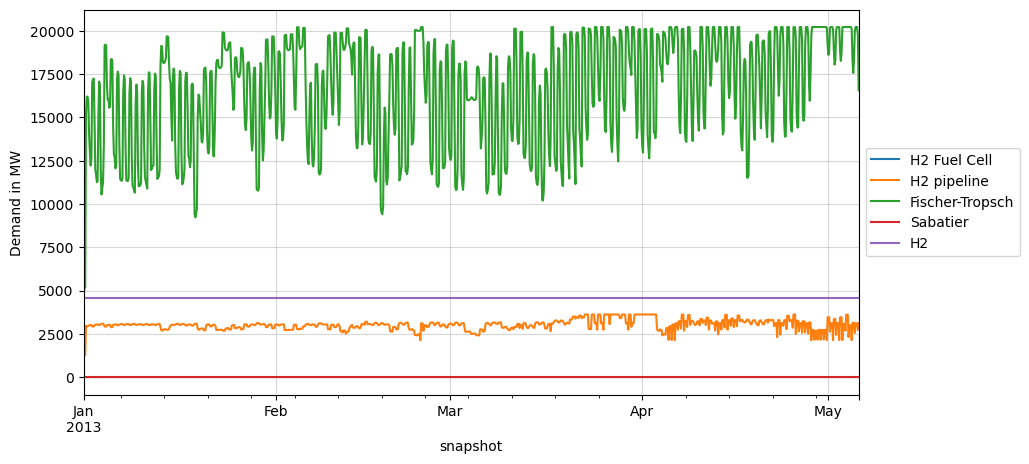

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
links.loc[:, carrier_links].iloc[:1000].plot(ax=ax)
# Legend position to the right outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("Demand in MW")
ax.grid(alpha = 0.5)
plt.show()

### Oil storage

In [18]:
n.stores.carrier.unique()

array(['co2', 'co2 stored', 'oil', 'gas', 'H2', 'battery',
       'residential rural water tanks', 'services rural water tanks',
       'residential urban decentral water tanks',
       'services urban decentral water tanks',
       'urban central water tanks', 'biogas', 'solid biomass', 'Li ion'],
      dtype=object)

<AxesSubplot:xlabel='snapshot'>

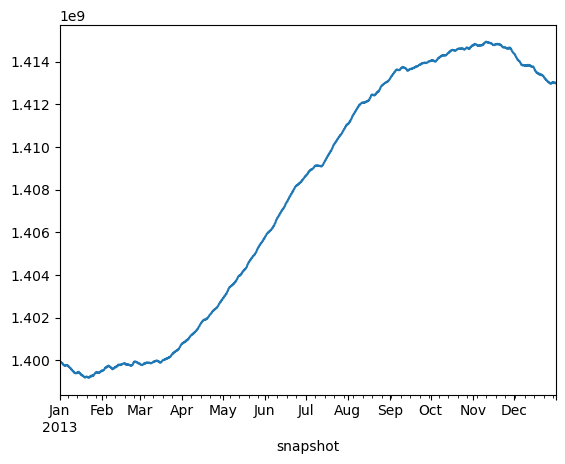

In [23]:
n.stores_t.e.groupby(n.stores.carrier, axis=1).sum().loc[: ,"oil"].plot() #.plot.bar(stacked=True)